<a href="https://colab.research.google.com/github/dimajyg/CCTV-human-tracking/blob/master/main_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install dependencies
!pip install ultralytics
!pip install albumentations
!pip install pytorch-lightning
!pip install tqdm

In [2]:
!wget https://motchallenge.net/data/MOT15.zip
!unzip -q MOT15.zip

--2025-04-29 07:59:18--  https://motchallenge.net/data/MOT15.zip
Resolving motchallenge.net (motchallenge.net)... 131.159.19.34, 2a09:80c0:18::1034
Connecting to motchallenge.net (motchallenge.net)|131.159.19.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1310994213 (1.2G) [application/zip]
Saving to: ‘MOT15.zip’

MOT15.zip           100%[===================>]   1.22G  20.1MB/s    in 70s     

2025-04-29 08:00:30 (17.8 MB/s) - ‘MOT15.zip’ saved [1310994213/1310994213]



In [3]:
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor

import albumentations as A
from ultralytics import YOLO

import glob
import os
from tqdm import tqdm
from pathlib import Path
import yaml

import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageDraw
from IPython.display import display

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Почему `YOLO`?
1. Легко дообучать
2. Внутри pytorch lightning
3. Есть logging и tensorboard
4. Может запускать в real-time при малых ресурсах
5. Мало весит
6. Легко Интегрируется с SORT-трекерами
7. Хорошее качество при детекции людей
  
Sources:  
[Object detection in real-time video surveillance using attention based transformer-YOLOv8 model](https://www.sciencedirect.com/science/article/pii/S1110016825000468#:~:text=YOLOv8%20is%20a%20real%2Dtime,class%20and%20real%2Dtime%20operation.)  
[SIMPLE ONLINE AND REALTIME TRACKING WITH A DEEP ASSOCIATION METRIC](https://arxiv.org/pdf/1703.07402)

In [4]:
DATASET_PATH = "/content/MOT15"
OUTPUT_DIR = "/content/output_checkpoints"

os.makedirs(OUTPUT_DIR, exist_ok=True)

In [5]:
SIZE_H = SIZE_W = 192 # 128

train_transform = A.Compose([
    A.Resize(SIZE_H, SIZE_W),
    A.HorizontalFlip(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
    ],
    bbox_params=A.BboxParams(format='yolo',
                             label_fields=['class_labels'],
                             min_visibility=0.3)
    )

standart_transform = A.Compose([
      A.Resize(SIZE_H, SIZE_W),
  ])

Почему `Albumentations` для аугментации?   
1. Быстро работает на CPU
2. Очень разнообразные аугментации
3. Могут работать с bounding box'ами
4. Легко пользоваться
  
Source:  
[Albumentations: fast and flexible image
augmentations](https://arxiv.org/pdf/1809.06839)

In [6]:
def collect_images(dataset_path):
    images = glob.glob(os.path.join(dataset_path, "**", "img1", "*.jpg"), recursive=True)
    return images

In [7]:
train_image_paths = collect_images(DATASET_PATH / Path('train'))
print(f"Found {len(train_image_paths)} train images")

test_image_paths = collect_images(DATASET_PATH / Path('test'))
print(f"Found {len(test_image_paths)} test images")

Found 5500 train images
Found 5783 test images


In [ ]:
def convert_mot_to_yolo(mot_dataset_root, output_labels_dir):

    os.makedirs(output_labels_dir, exist_ok=True)

    for mode in ["train", "test"]:
        mode_path = os.path.join(mot_dataset_root, mode)
        if not os.path.exists(mode_path):
            continue

        for seq in os.listdir(mode_path):
            seq_path = os.path.join(mode_path, seq)
            gt_path = os.path.join(seq_path, "gt/gt.txt")
            img_folder = os.path.join(seq_path, "img1")

            if not os.path.exists(gt_path) or not os.path.exists(img_folder):
                continue

            print(f"Processing sequence: {seq}")


            with open(gt_path, "r") as f:
                lines = f.readlines()

            annotations_per_frame = {}

            min_width_pixels = 5
            min_height_pixels = 5

            for line in lines:
                fields = line.strip().split(',')

                frame = int(float(fields[0]))
                id_ = int(float(fields[1]))
                bb_left = float(fields[2])
                bb_top = float(fields[3])
                bb_width = float(fields[4])
                bb_height = float(fields[5])
                conf = float(fields[6])
                class_id = int(float(fields[7]))
                visibility = float(fields[8])

                # Skip ignored or bad bboxes
                if conf == 0 or id_ == -1 or bb_width < min_width_pixels or bb_height < min_height_pixels:
                    continue

                # Read image size
                img_path = os.path.join(img_folder, f"{frame:06d}.jpg")
                if not os.path.exists(img_path):
                    continue

                img = cv2.imread(img_path)
                if img is None:
                    continue

                img_h, img_w = img.shape[:2]

                # Normalize
                x_center = (bb_left + bb_width / 2) / img_w
                y_center = (bb_top + bb_height / 2) / img_h
                width = bb_width / img_w
                height = bb_height / img_h

                # Clamp values (safety)
                x_center = min(max(x_center, 0.0), 1.0)
                y_center = min(max(y_center, 0.0), 1.0)
                width = min(max(width, 0.0), 1.0)
                height = min(max(height, 0.0), 1.0)

                Save
                label_line = f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n"

                if frame not in annotations_per_frame:
                    annotations_per_frame[frame] = []

                annotations_per_frame[frame].append(label_line)

            for frame, labels in annotations_per_frame.items():
                label_filename = f"{seq}_{frame:06d}.txt"
                label_path = os.path.join(output_labels_dir, label_filename)
                with open(label_path, "w") as label_file:
                    label_file.writelines(labels)

    print("\n✅ Done! All YOLO label files saved.")

In [ ]:
# Example call
convert_mot_to_yolo(mot_dataset_root="/content/MOT15", output_labels_dir="/content/MOT15_labels")

Processing sequence: Venice-2
Processing sequence: ETH-Sunnyday
Processing sequence: ETH-Pedcross2
Processing sequence: ADL-Rundle-8
Processing sequence: KITTI-17
Processing sequence: TUD-Campus
Processing sequence: ADL-Rundle-6
Processing sequence: KITTI-13
Processing sequence: ETH-Bahnhof
Processing sequence: PETS09-S2L1
Processing sequence: TUD-Stadtmitte

✅ Done! All YOLO label files saved.


In [ ]:
class MOTDataset(Dataset):
    def __init__(self, image_paths, label_root, transform=None):
        self.image_paths = image_paths
        self.label_root = label_root
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        parts = img_path.split('/')
        seq_name = parts[-3]
        frame_name = os.path.basename(img_path).split('.')[0]
        label_filename = f"{seq_name}_{frame_name}.txt"
        label_path = os.path.join(self.label_root, label_filename)

        image = Image.open(img_path).convert('RGB')
        image = np.array(image)

        boxes = []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_id, x_center, y_center, width, height = map(float, parts)
                        boxes.append([class_id, x_center, y_center, width, height])

        if not boxes:
            bboxes = []
            class_labels = []
        else:
            class_labels = [int(box[0]) for box in boxes]
            bboxes = [box[1:] for box in boxes]

        if self.transform and bboxes:

            transformed = self.transform(
                image=image,
                bboxes=bboxes,
                class_labels=class_labels
            )
            image = transformed['image']
            bboxes = transformed['bboxes']
            class_labels = transformed['class_labels']
            clamped_bboxes = []

            for bbox in bboxes:
                x_center, y_center, width, height = bbox

                x_min = max(0.0, min(1.0, x_center - width / 2))
                y_min = max(0.0, min(1.0, y_center - height / 2))
                x_max = max(0.0, min(1.0, x_center + width / 2))
                y_max = max(0.0, min(1.0, y_center + height / 2))

                if (x_max - x_min) < 0.01 or (y_max - y_min) < 0.01:
                    continue

                new_x_center = (x_min + x_max) / 2
                new_y_center = (y_min + y_max) / 2
                new_width = x_max - x_min
                new_height = y_max - y_min

                clamped_bboxes.append([new_x_center, new_y_center, new_width, new_height])

            bboxes = clamped_bboxes

        boxes = [[cls] + list(bbox) for cls, bbox in zip(class_labels, bboxes)]
        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0

        return image, boxes

In [ ]:
train_image_paths = collect_images("/content/MOT15" / Path('train'))
label_root = "/content/MOT15_labels"

train_img_paths, val_img_paths = train_test_split(
    train_image_paths,
    test_size=0.2,
    shuffle=True
)

train_dataset = MOTDataset(image_paths=train_img_paths, label_root=label_root, transform=train_transform)
val_dataset = MOTDataset(image_paths=val_img_paths, label_root=label_root, transform=standart_transform)

#### Проверим аугментированный трейновый датасет

In [ ]:
def visualize_sample_with_boxes(dataset, idx):
    img, boxes = dataset[idx]

    img = img.permute(1, 2, 0).cpu().numpy()
    img = (img * 255).clip(0, 255).astype(np.uint8)

    img_pil = Image.fromarray(img)
    draw = ImageDraw.Draw(img_pil)

    img_w, img_h = img_pil.size

    for box in boxes:

        class_id, x_center, y_center, width, height = box

        x_min = x_center - width / 2
        y_min = y_center - height / 2
        x_max = x_center + width / 2
        y_max = y_center + height / 2

        x_min = max(0.0, min(1.0, x_min))
        y_min = max(0.0, min(1.0, y_min))
        x_max = max(0.0, min(1.0, x_max))
        y_max = max(0.0, min(1.0, y_max))

        if x_max <= x_min or y_max <= y_min:
            continue

        x1 = x_min * img_w
        y1 = y_min * img_h
        x2 = x_max * img_w
        y2 = y_max * img_h

        if (x2 - x1) < 1 or (y2 - y1) < 1:
            continue

        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        draw.text((x1, y1 - 10), f"ID:{int(class_id)}", fill="red")

    return img_pil


def visualize_grid(dataset, num_images=8, rows=2, cols=4):
    import random
    fig, axes = plt.subplots(rows, cols, figsize=(16, 8))

    for i in range(num_images):
        smpl = random.randint(0, len(dataset) - 1)
        img_pil = visualize_sample_with_boxes(dataset, idx=smpl)

        ax = axes[i // cols, i % cols]
        ax.imshow(img_pil)
        ax.axis('off')
        ax.set_title(f"Sample {smpl}")

    plt.tight_layout()
    plt.show()

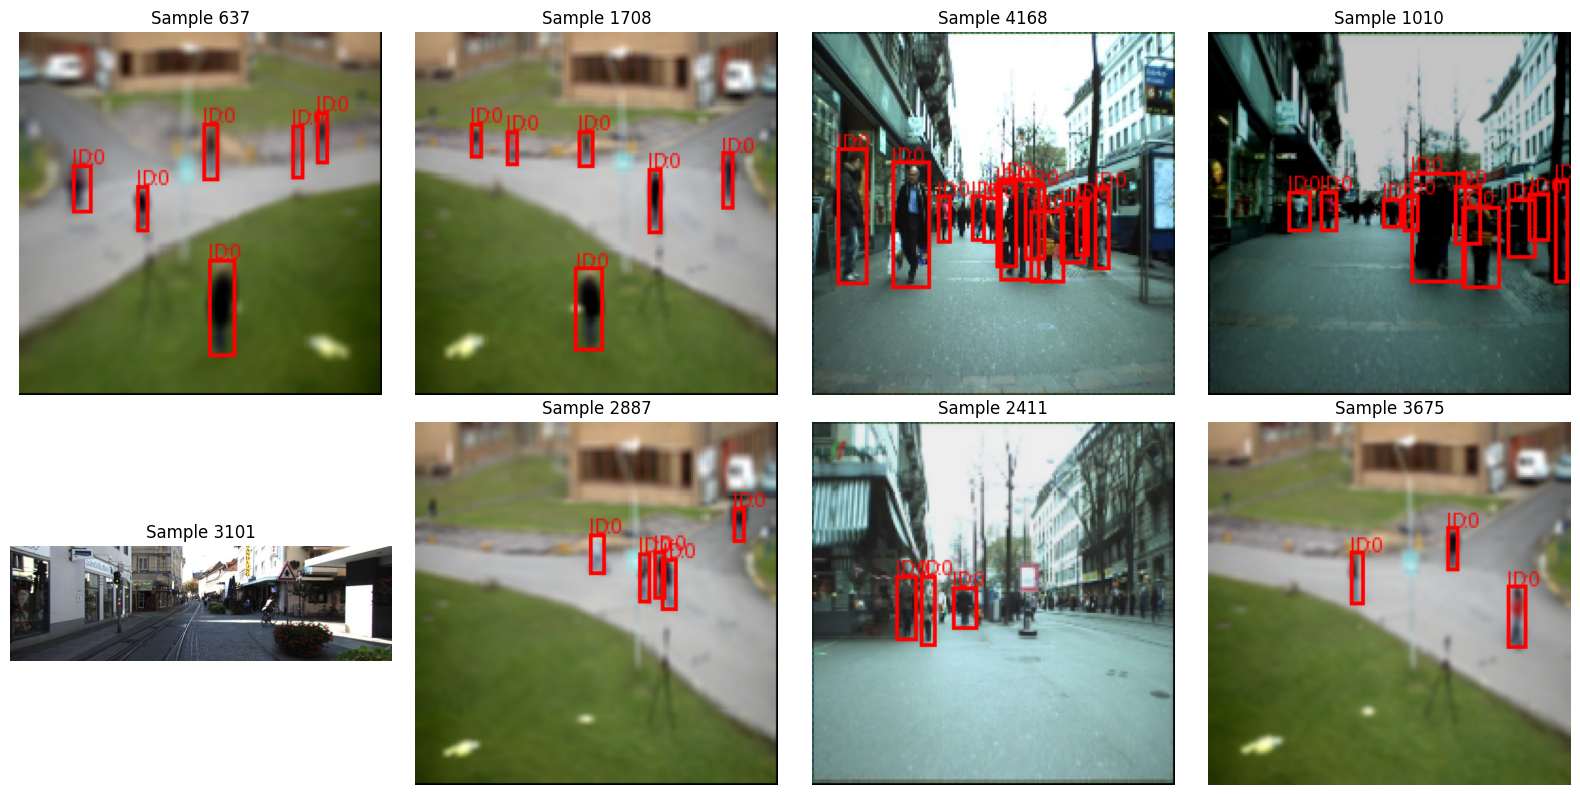

In [ ]:
visualize_grid(train_dataset, num_images=8, rows=2, cols=4)

#### Проверим валидационный датасет

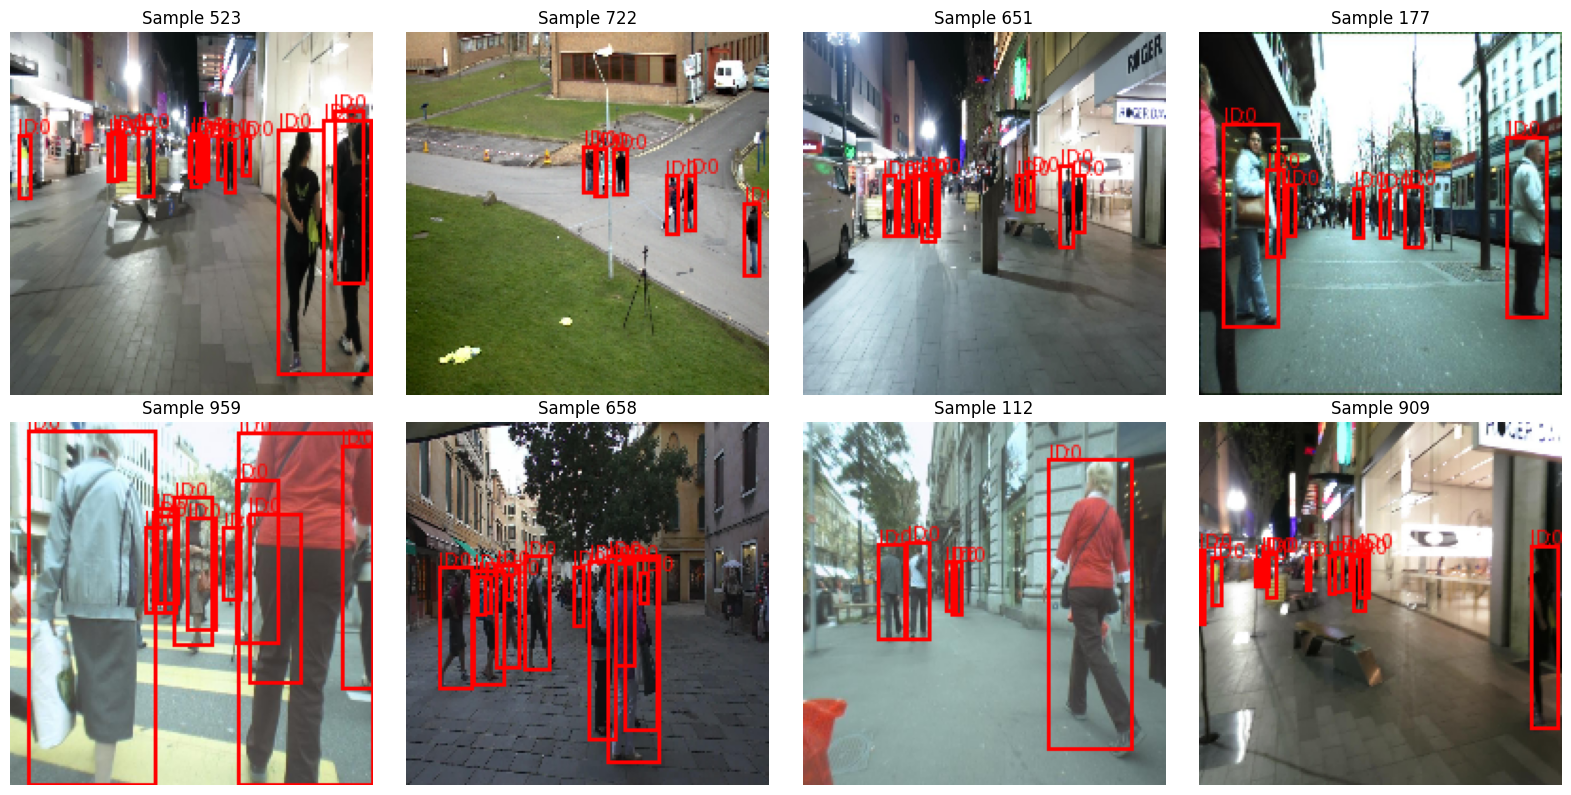

In [ ]:
visualize_grid(val_dataset, num_images=8, rows=2, cols=4)

#### Тестовый датасет & DataLoaders

In [ ]:
image_paths = collect_images("/content/MOT15" / Path('test'))
label_root = ""

test_dataset = MOTDataset(image_paths=image_paths, label_root=label_root, transform=standart_transform)

In [ ]:
def mot_collate_fn(batch):
    images, targets = list(zip(*batch))
    images = torch.stack(images, dim=0)
    return images, targets

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=mot_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, collate_fn=mot_collate_fn)

In [ ]:
for images, labels in train_loader:
    print(f"Train batch images shape: {images.shape}")
    print(f"Train batch labels shape: {len(labels)}")
    break

for images, labels in val_loader:
    print(f"Val batch images shape: {images.shape}")
    print(f"Val batch labels shape: {len(labels)}")
    break


Train batch images shape: torch.Size([8, 3, 192, 192])
Train batch labels shape: 8
Val batch images shape: torch.Size([8, 3, 192, 192])
Val batch labels shape: 8


#### Модель